<a href="https://colab.research.google.com/github/sebasbrowar/FisicaComputacional1/blob/main/Evaluacion1%5CEvaluacion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{Evaluación 1 - Sebastián Browarski Ruiz}$

## $\text{Bibliotecas}$

In [168]:
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

## $\text{Parte 1. Construcción de una Serie de Tiempo}$

In [169]:
# Observatorio Barrow, Alaska
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_brw_DailyData.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 151 renglones, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'value', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=151, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 
str_Nulo = -999.99
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['value', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Creamos la columna fecha, solo usaremos el año, mes y día
df_work2['Fecha'] = pd.to_datetime(df_work2.year*10000+df_work2.month*100+df_work2.day, format='%Y%m%d').copy()

df_work3 = df_work2.copy()

# Borramos las columnas innecesarias 
del df_work3['year']
del df_work3['month']
del df_work3['day']
del df_work3['hour']
del df_work3['minute']
del df_work3['second']
del df_work3['time_decimal']
del df_work3['site_code']
del df_work3['value_std_dev']
del df_work3['nvalue']
del df_work3['latitude']
del df_work3['longitude']
del df_work3['altitude']
del df_work3['elevation']
del df_work3['intake_height']
del df_work3['qcflag']

# La columna fecha será el índice
df_work3 = df_work3.set_index('Fecha')

df_work3.info()
print(df_work3.head())
print(df_work3.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17166 entries, 1973-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   15140 non-null  float64
dtypes: float64(1)
memory usage: 268.2 KB
            value
Fecha            
1973-01-01    NaN
1973-01-02    NaN
1973-01-03    NaN
1973-01-04    NaN
1973-01-05    NaN
             value
Fecha             
2019-12-27  416.86
2019-12-28  416.83
2019-12-29  417.01
2019-12-30  417.65
2019-12-31  417.46


In [170]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1980 a 2019
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1980-01', '2019-12' 

ts_80 = df_work3.loc[start:end].copy()
print(ts_80.head())
print(ts_80.tail())

             value
Fecha             
1980-01-01  341.38
1980-01-02  341.65
1980-01-03     NaN
1980-01-04     NaN
1980-01-05     NaN
             value
Fecha             
2019-12-27  416.86
2019-12-28  416.83
2019-12-29  417.01
2019-12-30  417.65
2019-12-31  417.46


In [171]:
print(ts_80['value'].head())
print(ts_80['value'].tail())

# Definimos nuestra serie de tiempo 
ts_test = ts_80['value'].copy()

Fecha
1980-01-01    341.38
1980-01-02    341.65
1980-01-03       NaN
1980-01-04       NaN
1980-01-05       NaN
Name: value, dtype: float64
Fecha
2019-12-27    416.86
2019-12-28    416.83
2019-12-29    417.01
2019-12-30    417.65
2019-12-31    417.46
Name: value, dtype: float64


## $\text{Parte 2. Análisis de la Serie de Tiempo}$

$\text{• Función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller.}$

In [172]:
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

$\text{• Prueba de estacionaridad de la serie de tiempo 'ts_test' en base al valor p.}$

In [173]:
ts_test.dropna(inplace=True)
ts_test.head()

Fecha
1980-01-01    341.38
1980-01-02    341.65
1980-01-06    342.32
1980-01-07    342.48
1980-01-10    342.37
Name: value, dtype: float64

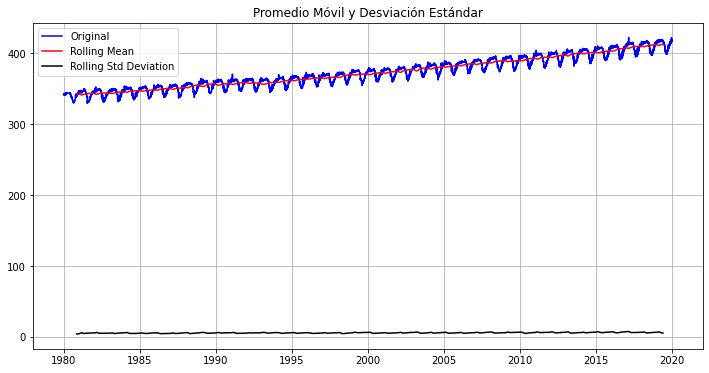

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -3.278635
p-value                            0.015861
#Lags Used                        32.000000
Number of Observations Used    13097.000000
Critical Value (1%)               -3.430849
Critical Value (5%)               -2.861761
Critical Value (10%)              -2.566887
dtype: float64


In [174]:
test_stationarity(ts_test)

$\text{Se puede observar que el valor p = 0.015861 < 0.05 por lo que podemos afirmar que la serie de tiempo es estacionaria con 99% de confianza.}$
$\text{Se puede decir que la serie es estacionaria, pues tanto el promedio móvil exponencial y la desviación estandar son constantes.}$

$\text{• Descomposición estacional de la serie 'ts_test', usando interpolación, y promedio móvil de 365 días.}$
$\text{También gráficas de las series que la componen.}$

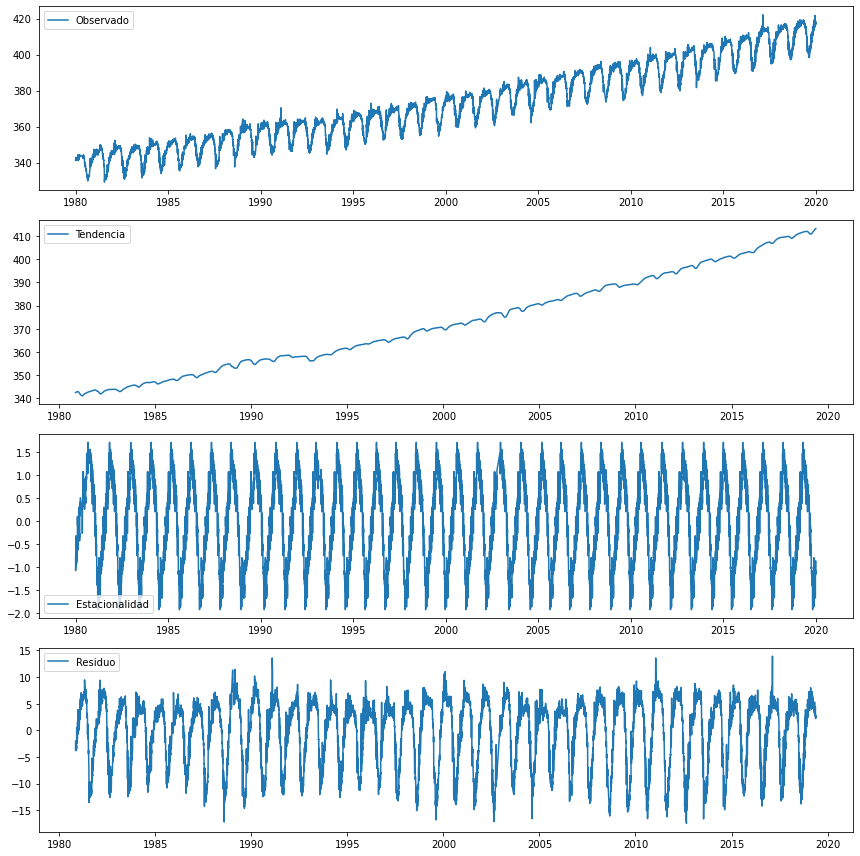

In [175]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test, label='Observado')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

$\text{Con las gráficas podemos observar que la tendencia está en crecimiento, y esto tiene lógica ya que se ha visto que conforme}$
$\text{pasan los años, los humanos cada vez generan más y más CO2 que afecta drásticamente al planeta. También se ve como}$
$\text{la estacionalidad tiene un movimiento oscilatorio, debido a las estaciones del año. Esto puede llegar a dar problemas}$
$\text{entonces se debe de desestacionalizar la serie para mejores resultados. Luego tenemos el residuo que nos muestra las}$ 
$\text{variaciones aleatorias alrededor de los componentes anteriores.}$

$\text{• Prueba de estacionaridad de la serie residuo.}$

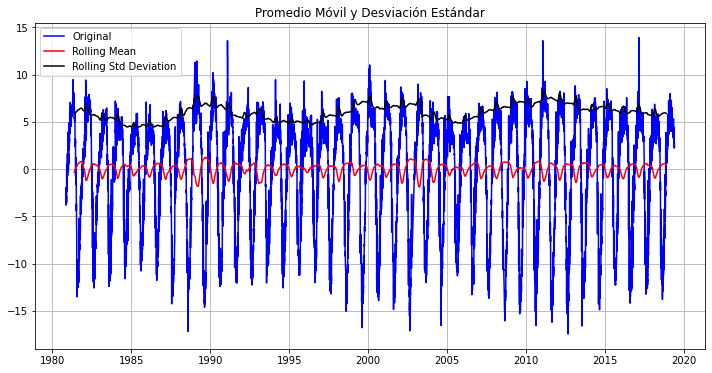

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.527396e+01
p-value                        4.675505e-28
#Lags Used                     4.100000e+01
Number of Observations Used    1.272400e+04
Critical Value (1%)           -3.430864e+00
Critical Value (5%)           -2.861767e+00
Critical Value (10%)          -2.566891e+00
dtype: float64


In [176]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_decompose = residue 
ts_test_decompose.dropna(inplace=True)
test_stationarity(ts_test_decompose)

$\text{• Promedio móvil centrado sobre 'ts_test' usando un periodo de 365 días, contrastado en una gráfica con la serie de CO2.}$

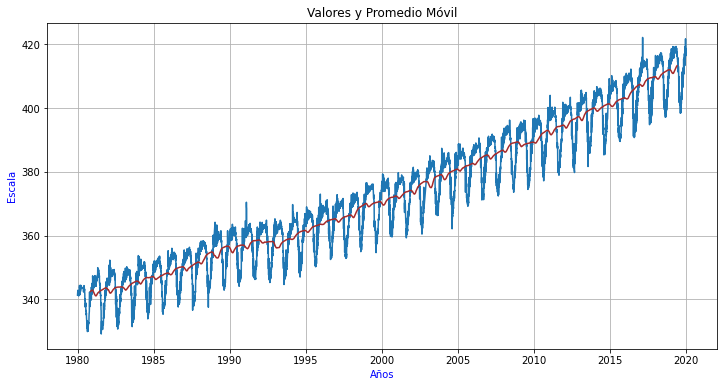

In [177]:
moving_avg = ts_test.rolling(365, center=True).mean()
plt.plot(ts_test)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

$\text{• Nuevo dataframe con la diferencia entre la serie original y el promedio móvil, y prueba de estacionaridad.}$

In [178]:
ts_test_moving_ave_diff = ts_test - moving_avg 
ts_test_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-06   NaN
1980-01-07   NaN
1980-01-10   NaN
Name: value, dtype: float64

In [179]:
ts_test_moving_ave_diff.dropna(inplace=True)
ts_test_moving_ave_diff.head()

Fecha
1980-11-10   -0.671671
1980-11-11   -2.758767
1980-11-12   -1.404055
1980-11-13   -1.709315
1980-11-14   -2.193918
Name: value, dtype: float64

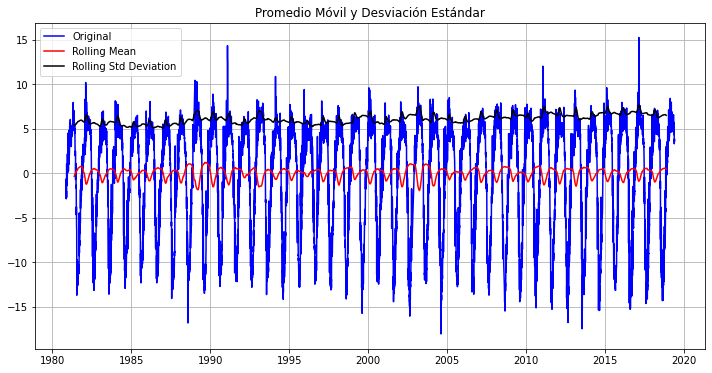

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.517151e+01
p-value                        6.381075e-28
#Lags Used                     4.100000e+01
Number of Observations Used    1.272400e+04
Critical Value (1%)           -3.430864e+00
Critical Value (5%)           -2.861767e+00
Critical Value (10%)          -2.566891e+00
dtype: float64


In [180]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada 
test_stationarity(ts_test_moving_ave_diff)

$\text{• Serie estacionaria usando la función de diferenciación shift con un periodo de 7 días, que utiliza menos puntos que el promedio móvil. }$

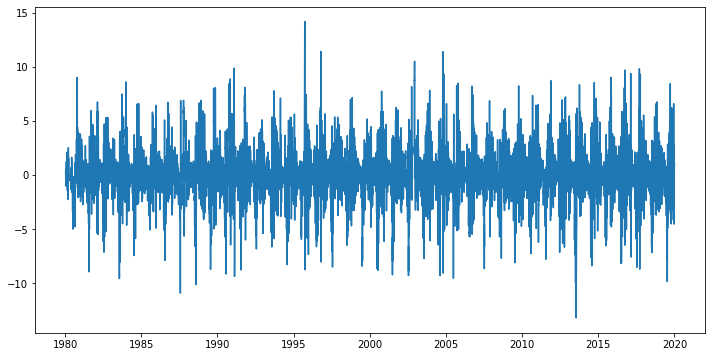

In [181]:
# Diferenciamos usando la función df.shift()
ts_test_diff = ts_test - ts_test.shift(periods=7)
plt.plot(ts_test_diff);

$\text{• Prueba de estacionaridad de la serie de tiempo usando la función shift con un periodo de 7 días.}$

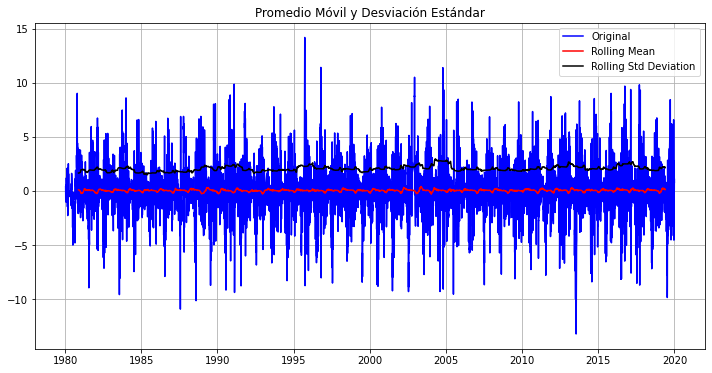

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.452210e+01
p-value                        5.503122e-27
#Lags Used                     4.100000e+01
Number of Observations Used    1.308100e+04
Critical Value (1%)           -3.430850e+00
Critical Value (5%)           -2.861761e+00
Critical Value (10%)          -2.566888e+00
dtype: float64


In [182]:
# Probamos la estacionaridad
ts_test_diff.dropna(inplace=True)
test_stationarity(ts_test_diff)

$\text{• Construcción del modelo ARIMA de la serie 'ts_test_diff', calculando los parámetros p, q y utilizando d=1.}$

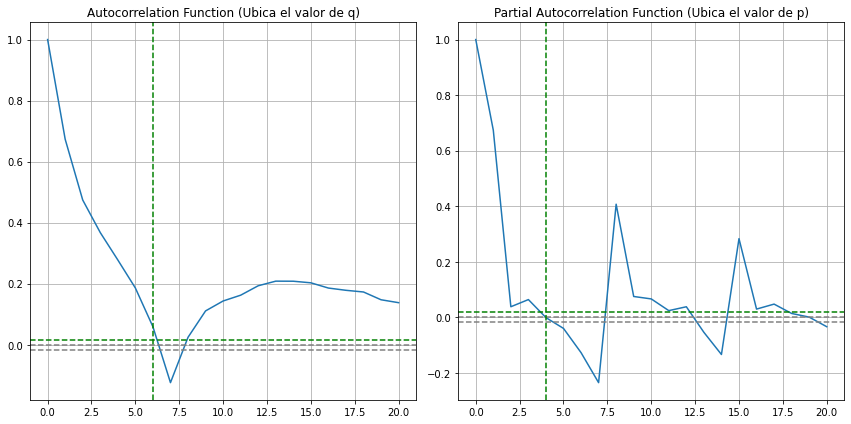

In [183]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_diff, nlags=20)
lag_pacf = pacf(ts_test_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

$\text{Las líneas punteadas alrededor de cero representan los intervalos de confianza y nos serviran para determinar los valores}$
$\text{p y q del modelo ARIMA.}$
$\text{p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 4, por lo que p=4.}$
$\text{q es donde cruza la ACF el primer nivel de confianza superior, cercano a 6, por lo que haremos q=6.}$
$\text{Con estos dos valores construiremos los modelos ARIMA correspondientes.}$

$\text{• Para seleccionar el mejor modelo, calculamos el Criterio de Información de Akaike (AIC) de los modelos: AR(p), MA(q),}$ 
$\text{y ARIMA (p,d,q).}$

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                13129
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -20206.187
Method:                       css-mle   S.D. of innovations              1.128
Date:                Thu, 25 Feb 2021   AIC                          40424.374
Time:                        00:20:11   BIC                          40469.270
Sample:                             1   HQIC                         40439.368
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0058      0.006      0.964      0.335      -0.006       0.017
ar.L1.D.value    -0.2454      0.009    -28.201      0.000      -0.262      -0.228
ar.L2.D.value    -0.2084      0.009    -

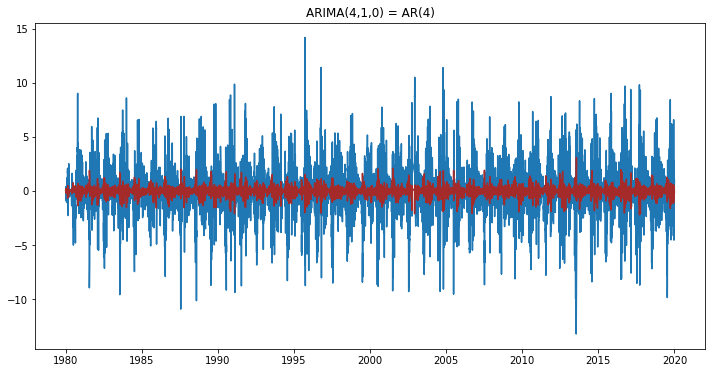

In [184]:
# Modelo AR(p): (p,d,q) = (4,1,0) 
model = ARIMA(ts_test, order=(4,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(4,1,0) = AR(4)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                13129
Model:                 ARIMA(0, 1, 6)   Log Likelihood              -20189.003
Method:                       css-mle   S.D. of innovations              1.126
Date:                Thu, 25 Feb 2021   AIC                          40394.006
Time:                        00:20:19   BIC                          40453.867
Sample:                             1   HQIC                         40413.998
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0058      0.006      1.028      0.304      -0.005       0.017
ma.L1.D.value    -0.2504      0.009    -28.665      0.000      -0.267      -0.233
ma.L2.D.value    -0.1550      0.009    -

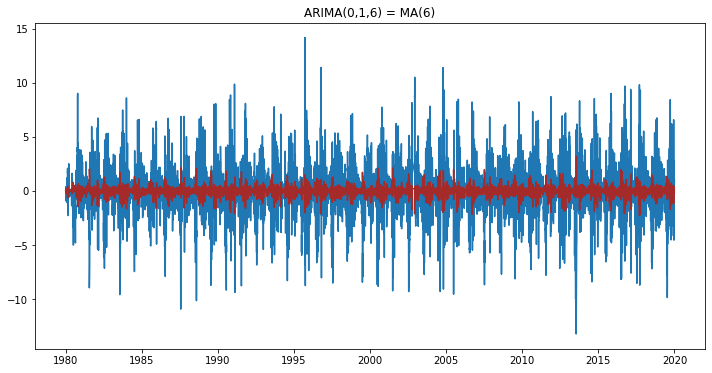

In [185]:
# Modelo MA(q): (p,d,q) = (0,1,6) 
model = ARIMA(ts_test, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                13129
Model:                 ARIMA(4, 1, 6)   Log Likelihood              -20006.596
Method:                       css-mle   S.D. of innovations              1.111
Date:                Thu, 25 Feb 2021   AIC                          40037.191
Time:                        00:21:28   BIC                          40126.982
Sample:                             1   HQIC                         40067.178
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0057      0.011      0.534      0.594      -0.015       0.027
ar.L1.D.value     0.3842      0.032     11.848      0.000       0.321       0.448
ar.L2.D.value     0.6891      0.015     

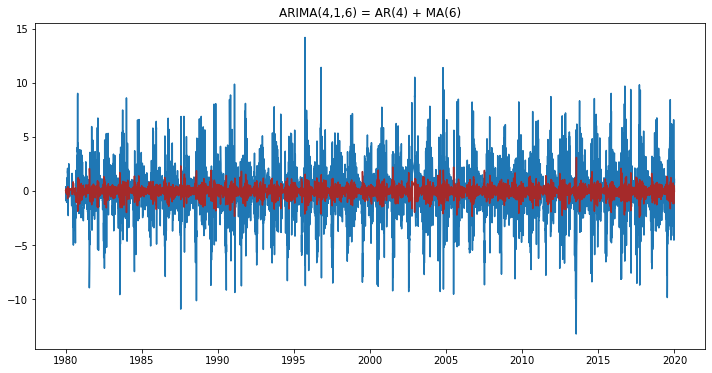

In [186]:
# Modelo ARIMA(p): (p,d,q) = (4,1,6) 
model = ARIMA(ts_test, order=(4,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(4,1,6) = AR(4) + MA(6)')
print(results_ARIMA.summary())

$\text{Verificamos el Criterio de Información de Akaike (AIC)}$

*   $\text{ARIMA(4,1,0): AIC = 40424.374}$
*   $\text{ARIMA(0,1,6): AIC = 40394.006}$
*   $\text{ARIMA(4,1,6): AIC = 40037.191 <- Es el menor AIC}$

$\text{Al final, podemos ver que ARIMA(4,1,6) es el mejor modelo de los 3 explorados.}$

$\text{• Contraste de la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.}$

In [187]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

print(predictions_ARIMA_diff)                                          

Fecha
1980-01-02    0.005741
1980-01-06   -0.044467
1980-01-07   -0.189679
1980-01-10   -0.187328
1980-01-11   -0.086182
                ...   
2019-12-27    0.121705
2019-12-28    0.312663
2019-12-29    0.266546
2019-12-30    0.075251
2019-12-31   -0.036651
Length: 13129, dtype: float64


In [188]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test)
predictions_ARIMA = pd.Series(ts_test, index = ts_test.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff)
print(predictions_ARIMA.head())
print(predictions_ARIMA.tail())

Fecha
1980-01-01           NaN
1980-01-02    341.655741
1980-01-06    342.275533
1980-01-07    342.290321
1980-01-10    342.182672
dtype: float64
Fecha
2019-12-27    416.981705
2019-12-28    417.142663
2019-12-29    417.276546
2019-12-30    417.725251
2019-12-31    417.423349
dtype: float64


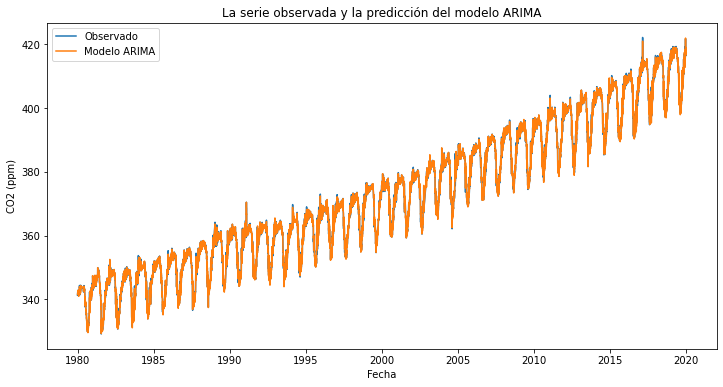

In [189]:
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráficas
plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');

# Ejes
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')

# Título y leyenda
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

$\text{• Calculo del error de la raíz cuadrada promedio RMSE.}$

In [190]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.3839213275158287


$\text{• Contraste de los 5 últimos años de la Serie de CO2 y el modelo ARIMA para ver mas a detalle el modelo.}$

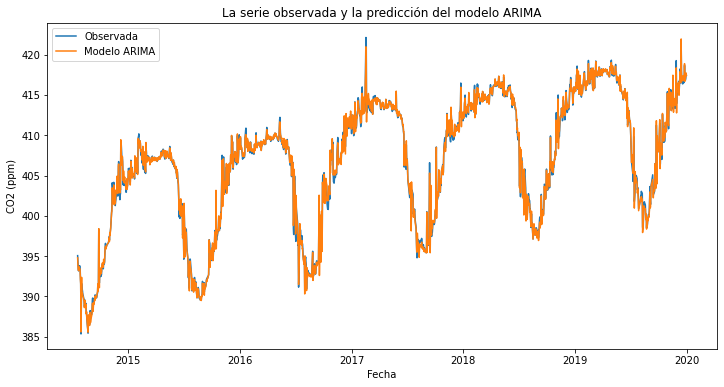

In [191]:
# Graficamos sólo los útimos 5 años de datos de la serie
ts_test_last = ts_test.tail(1825)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)

plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');

plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');